<a href="https://colab.research.google.com/github/velasoka-repo/EVA4/blob/master/Session-5/EVA4_S5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Github Link](https://github.com/velasoka-repo/EVA4/blob/master/Session-5/EVA4_S5_1.ipynb)

#Target:
1. Basic Transforms (ToTensor, Normalize)
2. Basic Data Loader (Train & Test)
3. Basic CNN Model & reducing parameter without fancy transforms
4. Basic Training  & Test Loop

#Results:
1. Parameters: 1.6M
2. Best Training Accuracy: 99.95
3. Best Test Accuracy: 99.26%
4. Epochs: 15

#Analysis:
1. Simple Model with lots of parameter
2. Train Accuracy is increasing for each epoch
3. Test Accuracy is not stable (Accuracy is going UP & DOWN)
4. Seeing overfitting (Train: `99.95%`, Test: `99.08%`)

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

Applying following three transformation

1.   Compose - group multiple transform into sequential transform
2.   ToTensor - Convert numpy | PILImage to tensor and convert range between 0-1 
`(i.e) array/255`
3. Normalize - input data(train & test) is normalized besed on `mean` & `std` 
`(i.e) (i'th value - mean)/std => final i'th range becomes (-1, 1)`

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 6

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])
--------------------------------------------------


Text(0.5, 0, 'tensor(4)')

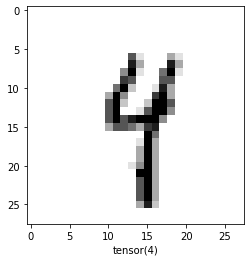

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.shape)
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape) #this shape first dimension is based on `batch size`
print(labels.shape) #shape == `batch size`

print("-"*50)
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.xlabel(labels[0])


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

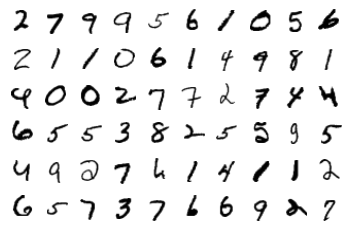

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self, fm_size):
        super(Net, self).__init__()
        self.num_classes = 10
        self.fm_size = fm_size

        self.pool = nn.MaxPool2d(2, 2)

        #Group-1
        self.conv1 = nn.Conv2d(1, self.fm_size, 3, padding=1)
        self.conv2 = nn.Conv2d(self.fm_size, self.fm_size*2, 3, padding=1)

        #Group-2
        self.fm_size *= 2
        self.conv3 = nn.Conv2d(self.fm_size, self.fm_size*2, 3, padding=1)
        self.fm_size *= 2 
        self.conv4 = nn.Conv2d(self.fm_size, self.fm_size*2, 3, padding=1)

        #Group-3
        self.fm_size *= 2 
        self.conv5 = nn.Conv2d(self.fm_size, self.fm_size*2, 3)
        self.fm_size *= 2 
        self.conv6 = nn.Conv2d(self.fm_size, self.fm_size*2, 3)

        #Group-4
        self.fm_size *= 2 
        self.conv7 = nn.Conv2d(self.fm_size, self.num_classes, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)

        x = self.conv7(x)
        
        x = x.view(-1, 10) #flatten the array to match with number of classes
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Available device: {device}")
model = Net(16).to(device)
summary(model, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 32, 28, 28]           4,640
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
            Conv2d-5          [-1, 128, 14, 14]          73,856
         MaxPool2d-6            [-1, 128, 7, 7]               0
            Conv2d-7            [-1, 256, 5, 5]         295,168
            Conv2d-8            [-1, 512, 3, 3]       1,180,160
            Conv2d-9             [-1, 10, 1, 1]          46,090
Total params: 1,618,570
Trainable params: 1,618,570
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.75
Params size (MB): 6.17
Estimated Total Size (MB): 6.93
----------------

# Training and Testing

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(iterable=train_loader, total=len(train_loader), position=0)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net(16).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.10466472059488297 Batch_id=468 Accuracy=79.76: 100%|██████████| 469/469 [00:09<00:00, 47.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0708, Accuracy: 9790/10000 (97.90%)

EPOCH: 2


Loss=0.017811983823776245 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:09<00:00, 47.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9875/10000 (98.75%)

EPOCH: 3


Loss=0.02518056146800518 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:09<00:00, 47.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.02879549004137516 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:09<00:00, 47.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9873/10000 (98.73%)

EPOCH: 5


Loss=0.011801838874816895 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:09<00:00, 47.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.01719079352915287 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:10<00:00, 46.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.02351118065416813 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:10<00:00, 46.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.009292860515415668 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:10<00:00, 46.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9900/10000 (99.00%)

EPOCH: 9


Loss=0.0025491516571491957 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:10<00:00, 46.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9904/10000 (99.04%)

EPOCH: 10


Loss=0.03616831824183464 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:10<00:00, 45.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.0004644890723284334 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:10<00:00, 46.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.0001373887062072754 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:10<00:00, 46.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9898/10000 (98.98%)

EPOCH: 13


Loss=0.0007542471284978092 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:10<00:00, 46.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9909/10000 (99.09%)

EPOCH: 14


Loss=0.0010835230350494385 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:10<00:00, 46.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9918/10000 (99.18%)

EPOCH: 15


Loss=6.941954052308574e-05 Batch_id=468 Accuracy=99.95: 100%|██████████| 469/469 [00:10<00:00, 46.54it/s]



Test set: Average loss: 0.0376, Accuracy: 9908/10000 (99.08%)



# Accuracy Graph

Text(0.5, 1.0, 'Test Accuracy')

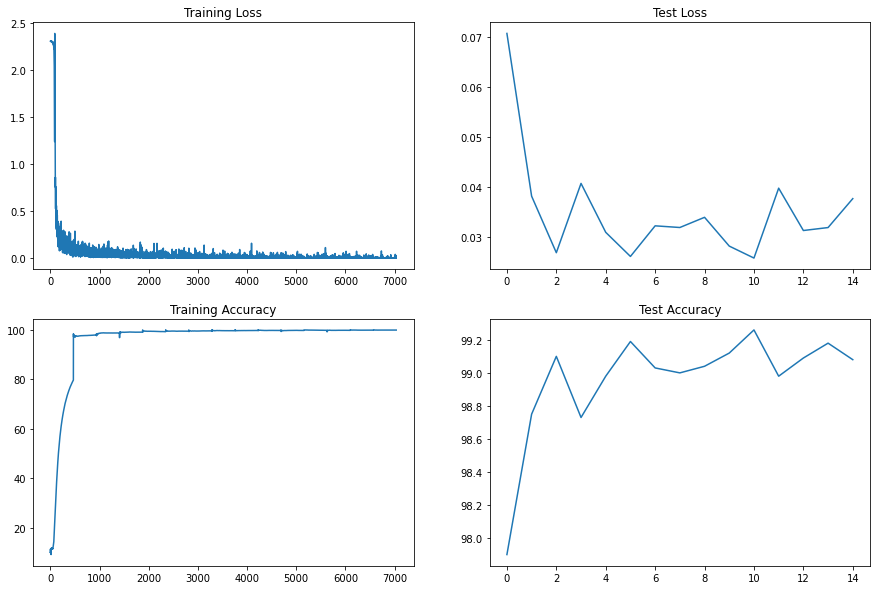

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")